<a id='sec0'></a>
# Testing basic_classification.py code

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import gensim
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

#### Loading data

In [3]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    #sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    #data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    #description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    #whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,quant_methods,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast, cancer, tissue, lysate, reduction, al...","[proteomic, datum, analysis, proteome, discove...","[current, prognostic, factor, insufficient, pr...",itraq,0,0,0,0,1,0
1,PXD000164,"[protein, extraction, catheter, biofilm, small...","[mass, spectrometric, analyse, the, tryptic, d...","[long, term, catheterization, lead, inevitably...",label free,0,0,0,0,0,1


In [5]:
X = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T
y = np.array(df.silac)

In [6]:
X.shape, y.shape

((2387, 22736), (2387,))

In [11]:
from importlib import reload

In [7]:
import basic_classification as bclf

In [87]:
reload(bclf)

<module 'basic_classification' from '/home/ryohayama/Python/b13logy_public/nlp/basic_classification.py'>

========== 5-fold CV Result ==========
accuracy : 0.87 +/- 0.038
precision : 0.95 +/- 0.023
recall : 0.42 +/- 0.107
f1 : 0.57 +/- 0.105
average precision : 0.78 +/- 0.043
brier loss : 0.09 +/- 0.017
ROC AUC : 0.91 +/- 0.028


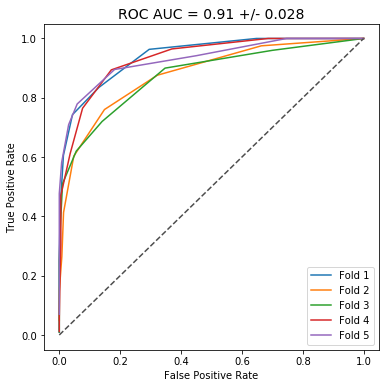

In [88]:
session = bclf.MyCVClassifier(X, y, CVFold=5, verbose=False)
session.run(print_output=True)
session.plot_roc()

========== 5-fold CV Result ==========
accuracy : 0.94 +/- 0.021
precision : 0.96 +/- 0.036
recall : 0.76 +/- 0.073
f1 : 0.85 +/- 0.046
average precision : 0.93 +/- 0.028
brier loss : 0.05 +/- 0.018
ROC AUC : 0.97 +/- 0.017


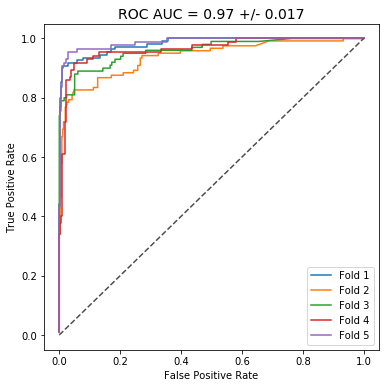

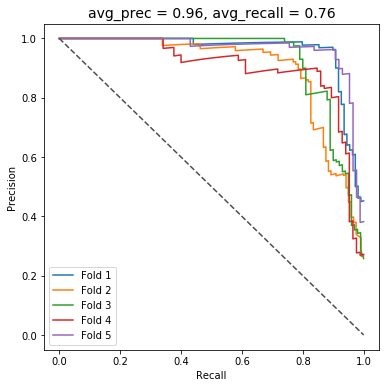

In [89]:
session = bclf.MyCVClassifier(X, y, CVFold=5, verbose=False, classifier_name='Logistic Regression',
                                                 classifier=LogisticRegression(C=1, penalty='l1'))
session.run(print_output=True)
session.plot_roc()
session.plot_precision_recall()

#### Functions for classification tasks

In [5]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        t = np.linspace(0, 1, 10)
        ax1.plot(t, t, ls='--', lw=0.5, color='0.3')
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: %s (\'%s\')' % (clf_label, target_label))
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: %s (\'%s\')' % (clf_label, target_label))
            ax2.legend()

        fig.tight_layout()
    return

<a id='sec4'></a>
## ms1_label_free

#### Feature Selection

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC 5-fold CV stats ==========
accuracy: 0.86 +/- 0.029
precision: 0.00 +/- 0.000
recall: 0.00 +/- 0.000
f1: 0.00 +/- 0.000
average_precision: 0.40 +/- 0.014
roc_auc: 0.76 +/- 0.044
Brier_loss: 0.12 +/- 0.021


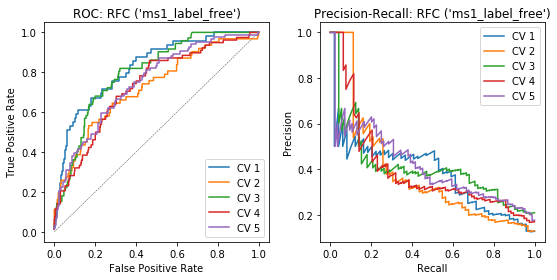

In [6]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=8)
initial_results = classifyCV(rfc, protocols_tfidf, df.ms1_label_free,
    name='RFC', n_splits=5, num_terms=22736)
summarize_results(initial_results, clf_label='RFC', target_label='ms1_label_free')

In [7]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

(22736, 742)

In [8]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    22736.000000
mean         0.000044
std          0.000394
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%          0.001393
max          0.020351
dtype: float64

In [9]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ >= 0.0001).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.0005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds4 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]
X4 = X0[:, new_inds4]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)
print('Shape X3   :', X4.shape)

Shape before: (2387, 22736)
Shape X1   : (2387, 712)
Shape X2   : (2387, 548)
Shape X3   : (2387, 355)
Shape X3   : (2387, 26)


In [10]:
# Check fraction of ms1_label_free class
print('Fraction with ms1_label_free = %.2f%%' % (100*df.ms1_label_free.sum()/len(df)))

Fraction with ms1_label_free = 14.45%


##### With RFC

In [11]:
rfcX1 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)
rfcX4 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X2, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)
res_X4 = classifyCV(rfcX4, X4, df.ms1_label_free, name='RFC', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC with X1 10-fold CV stats ==========
accuracy: 0.86 +/- 0.040
precision: 0.68 +/- 0.472
recall: 0.05 +/- 0.070
f1: 0.09 +/- 0.115
average_precision: 0.49 +/- 0.087
roc_auc: 0.83 +/- 0.036
Brier_loss: 0.10 +/- 0.025
========== RFC with X2 10-fold CV stats ==========
accuracy: 0.86 +/- 0.039
precision: 0.66 +/- 0.472
recall: 0.05 +/- 0.070
f1: 0.09 +/- 0.113
average_precision: 0.49 +/- 0.086
roc_auc: 0.83 +/- 0.042
Brier_loss: 0.11 +/- 0.026
========== RFC with X3 10-fold CV stats ==========
accuracy: 0.86 +/- 0.040
precision: 0.47 +/- 0.506
recall: 0.05 +/- 0.073
f1: 0.09 +/- 0.121
average_precision: 0.48 +/- 0.082
roc_auc: 0.82 +/- 0.043
Brier_loss: 0.11 +/- 0.025
========== RFC with X4 10-fold CV stats ==========
accuracy: 0.87 +/- 0.034
precision: 0.66 +/- 0.144
recall: 0.15 +/- 0.059
f1: 0.24 +/- 0.075
average_precision: 0.43 +/- 0.073
roc_auc: 0.76 +/- 0.040
Brier_loss: 0.11 +/- 0.023


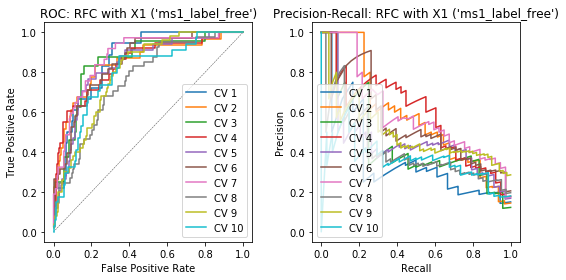

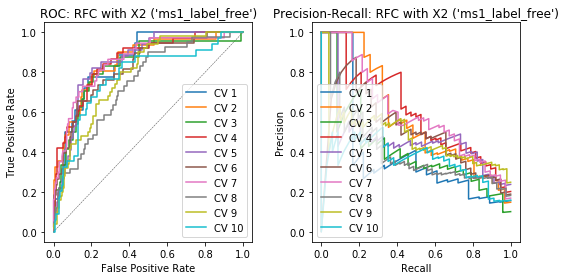

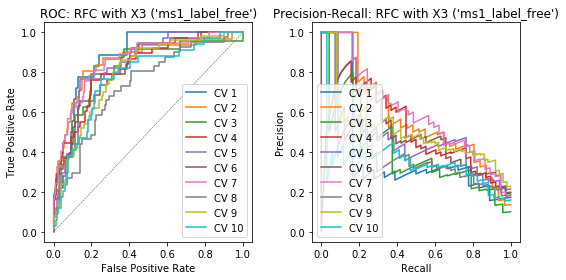

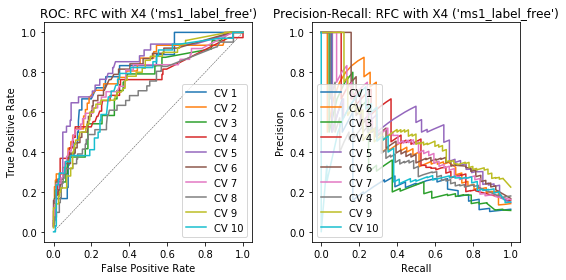

In [12]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X4, clf_label='RFC with X4', target_label='ms1_label_free', plot_result=True)

#### With LR

In [13]:
lrX1 = LogisticRegression(penalty='l1', C=1)
lrX2 = LogisticRegression(penalty='l1', C=1)
lrX3 = LogisticRegression(penalty='l1', C=1)
lrX4 = LogisticRegression(penalty='l1', C=1)

res_X1lr = classifyCV(lrX1, X1, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)
res_X4lr = classifyCV(lrX4, X4, df.ms1_label_free, name='LR', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


========== LR with X1 10-fold CV stats ==========
accuracy: 0.85 +/- 0.035
precision: 0.50 +/- 0.351
recall: 0.07 +/- 0.058
f1: 0.11 +/- 0.089
average_precision: 0.40 +/- 0.086
roc_auc: 0.81 +/- 0.055
Brier_loss: 0.11 +/- 0.025
========== LR with X2 10-fold CV stats ==========
accuracy: 0.86 +/- 0.038
precision: 0.57 +/- 0.388
recall: 0.08 +/- 0.090
f1: 0.12 +/- 0.126
average_precision: 0.41 +/- 0.095
roc_auc: 0.80 +/- 0.058
Brier_loss: 0.11 +/- 0.025
========== LR with X3 10-fold CV stats ==========
accuracy: 0.86 +/- 0.039
precision: 0.57 +/- 0.386
recall: 0.08 +/- 0.089
f1: 0.13 +/- 0.125
average_precision: 0.42 +/- 0.097
roc_auc: 0.81 +/- 0.060
Brier_loss: 0.11 +/- 0.025
========== LR with X4 10-fold CV stats ==========
accuracy: 0.86 +/- 0.036
precision: 0.48 +/- 0.404
recall: 0.08 +/- 0.085
f1: 0.12 +/- 0.127
average_precision: 0.37 +/- 0.104
roc_auc: 0.73 +/- 0.049
Brier_loss: 0.11 +/- 0.025


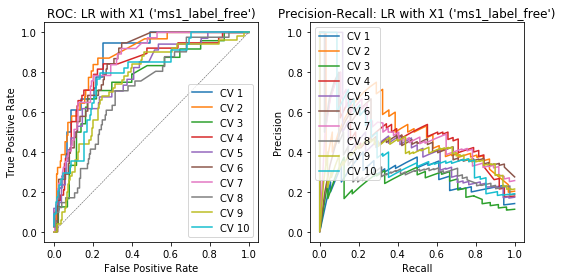

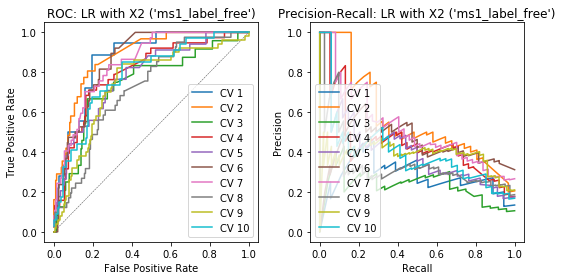

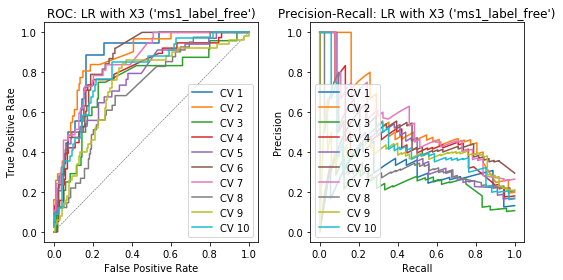

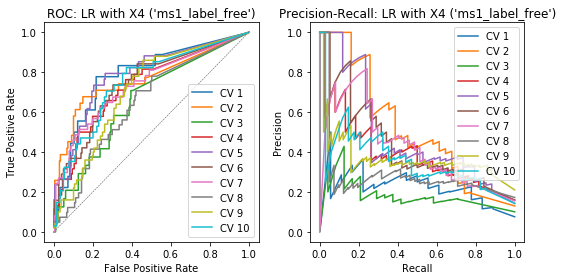

In [14]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='ms1_label_free', plot_result=True)
summarize_results(res_X4lr, clf_label='LR with X4', target_label='ms1_label_free', plot_result=True)

In [15]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [16]:
inds_collection = [new_inds2, new_inds3]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

========== Feature Set 2 ==========
analysis
analyze
cancer
control
dataset
datum
discoverer
express
expression
external
follow
group
include
indicate
itraq
labeling
lc
level
orbitrap
protein
proteome
provide
require
sample
search
set
top
total
unique
acetone
acn
adapt
al
analyse
approach
base
biological
brilliant
bsa
calculate
centrifuge
charge
cold
column
concentrate
constant
couple
data
database
dependent
determine
digest
divide
dtt
elution
enable
et
extract
extraction
fdr
file
fragment
gel
germany
gradient
great
human
ice
identification
import
incubate
intensity
iodoacetamide
kda
keep
least
length
mass
measure
methanol
methionine
min
ml
mm
modification
nlc
normalization
obtain
operate
option
pack
page
pellet
perform
ph
phase
ppm
present
profile
protease
quantification
quantify
raw
reference
replicate
result
rt
scan
scientific
second
see
separation
series
stain
step
store
sum
system
this
thus
tolerance
transfer
trap
trichloroacetic
tris
two
type
urea
use
variable
version
waltham
was